# Maintenance

Contrat de maintenance

L’objectif est de déterminer au bout de combien de temps le modèle de clustering entraîné initialement proposé devient obsolète (quand les prédictions, « predict », ne sont plus pertinentes), nécessitant d’entraîner un nouveau modèle de clustering.

#Import

##Librairies

In [ ]:
pip install kmodes

In [ ]:
# import des librairies
import pandas as pd
import numpy as np

# Pour afficher les graphiques dans la continuité du code,
# et non pas dans une fenêtre à part:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as st
import matplotlib.cm as cm
import plotly.express as px

#Anova
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats as sms

#PCA
from sklearn.decomposition import PCA
from matplotlib.collections import LineCollection
from sklearn import metrics
from sklearn.preprocessing import normalize

#Processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split

#Clustering
from sklearn.cluster import DBSCAN, KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score

from kmodes.kmodes import KModes
import plotly.graph_objects as go
import scipy.cluster.hierarchy as shc

#Date
import datetime as dt

In [ ]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)

<ipython-input-113-358864a12876>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


##Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OC Projet5/dataEcom_Exploration.csv', sep = ',')

Simulation pour la maintenance dans le cadre de la RFM

#Simulation par date

##Kmeans

Pour réaliser notre segmentation on se basera sur la méthode kmeans.

La segmentation RFM prend en compte la **Récence** (date de la dernière commande), la **Fréquence** des commandes et le **Montant** ( de la derniere commande ou sur une période donnée) pour établir des segments de clients homogènes.

In [ ]:
# Recherche de la plus anciennes date d'achat
ancien = data["order_purchase_timestamp"].min()
ancien

'2016-09-04 21:15:19'

In [ ]:
# On définit les difinis les dates limites pour les dataset périodique

recent_init= '2017-09-17 23:59:59' # Date de fin de l'échantillon T0 - recent_init

In [ ]:
#On change le format d'affichage de la date
aammjj = str.split(str.split(recent_init)[0], "-")
NOW = dt.datetime(int(aammjj[0]), int(aammjj[1]), int(aammjj[2]))

In [ ]:
aammjj

['2017', '09', '17']

In [ ]:
NOW

datetime.datetime(2017, 9, 17, 0, 0)

In [ ]:
# Change the type of "order_purchase_timestamp" at datetime
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])

In [ ]:
data.dtypes

customer_unique_id          object        
customer_id                 object        
order_purchase_timestamp    datetime64[ns]
payment_value               float64       
review_score                float64       
dtype: object

In [ ]:
#On prends un echantillon de données d'une années pour réaliser un modèle
data_init = data[data["order_purchase_timestamp"] <= recent_init]

In [ ]:
# Table RFM
#
# Recency: Nombre de jours depuis le dernier achat
#
# Frequency: Nombre de fois que le client a acheter
#
# Monetary: Dépenses total du client


rfmTable = data_init.groupby('customer_unique_id').\
          agg({"order_purchase_timestamp": lambda x: (NOW - x.max()).days,
                "customer_id": lambda x: len(x.unique()),
                "payment_value": lambda x: sum(x)})

rfmTable['order_purchase_timestamp'] = rfmTable['order_purchase_timestamp'].astype(int)
rfmTable.rename(columns={'order_purchase_timestamp': 'recency',
                        'customer_id': 'frequency',
                        'payment_value': 'monetary_value'}, inplace=True)
segmented_rfm = rfmTable.copy() #Copie du tableau

In [ ]:
Scal = StandardScaler()
std_segmented_rfm = Scal.fit_transform(segmented_rfm.astype(float))
std_segmented_rfm

array([[ 1.18034003, -0.1567035 , -0.32490106],
       [ 1.26326819, -0.1567035 , -0.05368267],
       [-0.6164369 , -0.1567035 , -0.56776674],
       ...,
       [-0.06358246, -0.1567035 ,  8.08414241],
       [ 1.60880222, -0.1567035 , -0.2135275 ],
       [ 0.4478079 , -0.1567035 , -0.38712425]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

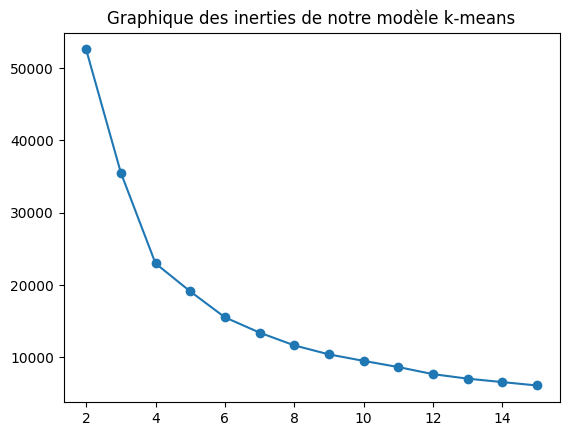

In [ ]:
#On vérifiera que le nombre de clusters idéale est toujours de 4 pour l'échantillon
#Appliquer le k-means
cluster_range = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

inertie = []

for c in cluster_range:
  kmeans = KMeans(init = 'k-means++', n_clusters = c).fit(std_segmented_rfm)
  inertie.append(kmeans.inertia_)

#Afficher l'inertie

plt.Figure()
plt.plot(cluster_range,inertie, marker ='o')
plt.title("Graphique des inerties de notre modèle k-means")
plt.show()

In [ ]:
kmeans_init = KMeans(n_clusters= 4, init = 'k-means++', random_state = 42).fit(std_segmented_rfm)
labels_init = kmeans_init.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
kmeans_init

KMeans(n_clusters=4, random_state=42)

In [ ]:
new_segmented_rfm_init = pd.DataFrame(data = std_segmented_rfm, columns =['recency', 'frequency', 'monetary_value'])
new_segmented_rfm_init['labels_kmeans'] = labels_init
new_segmented_rfm_init

,recency,frequency,monetary_value,labels_kmeans
0,1.180340,-0.156703,-0.324901,0
1,1.263268,-0.156703,-0.053683,0
2,-0.616437,-0.156703,-0.567767,3
3,-0.948150,-0.156703,-0.303424,3
4,-1.031078,-0.156703,0.401828,3
...,...,...,...,...
25004,-0.948150,-0.156703,-0.254783,3
25005,-1.238398,-0.156703,-0.457412,3
25006,-0.063582,-0.156703,8.084142,2
25007,1.608802,-0.156703,-0.213528,0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto

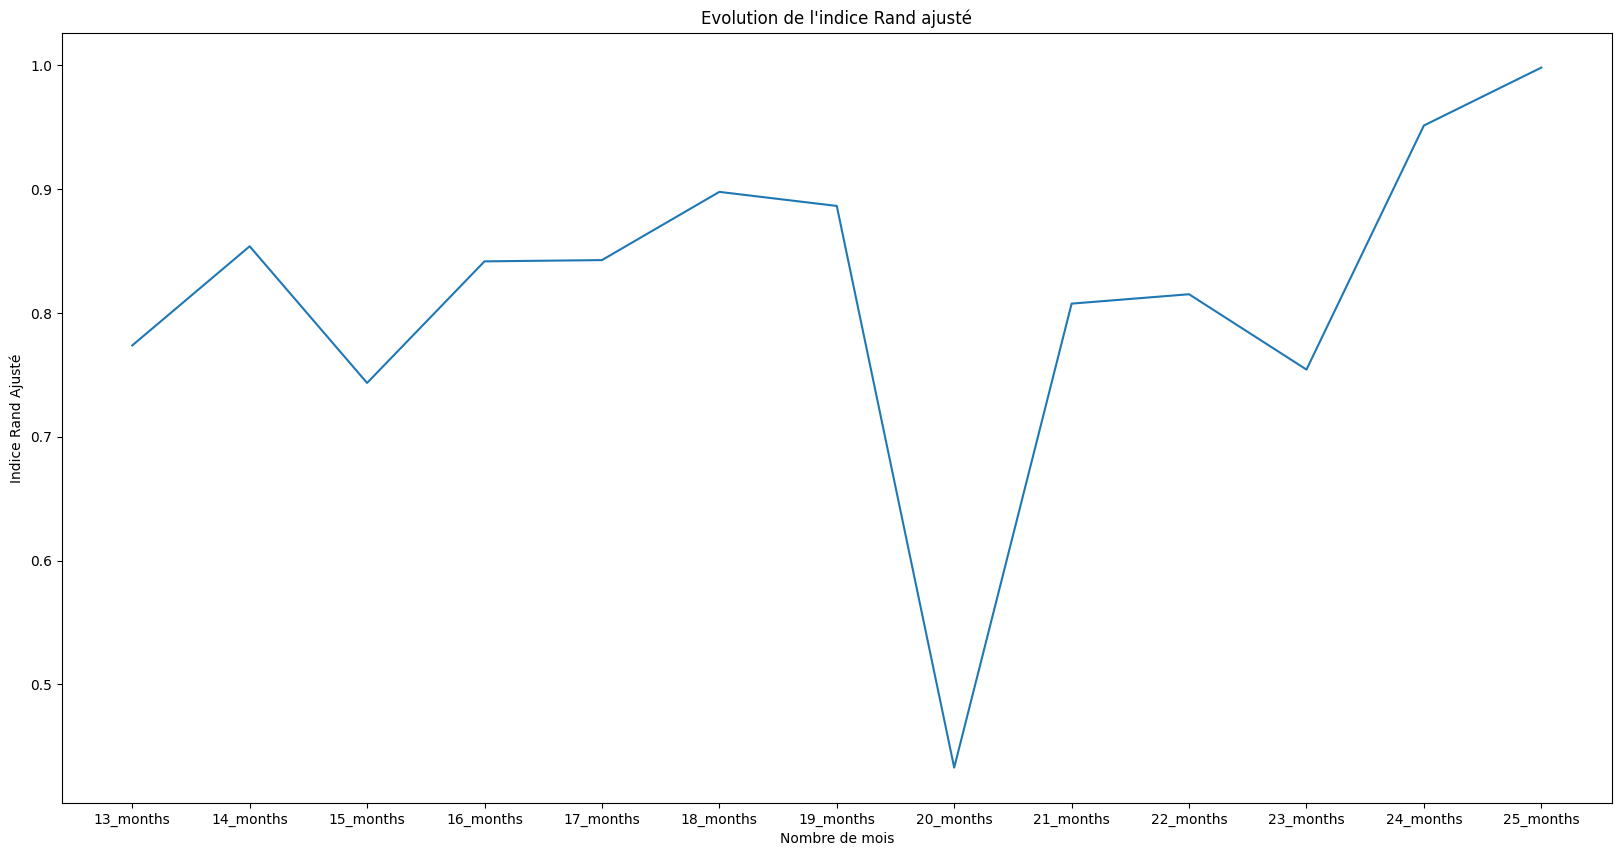

In [ ]:
#On entraine de nouveau modèle pour calculer les ARI
res = []
period =['2017-10-17 23:59:59',
         '2017-11-17 23:59:59',
         '2017-12-17 23:59:59',
         '2018-01-17 23:59:59',
         '2018-02-17 23:59:59',
         '2018-03-17 23:59:59',
         '2018-04-17 23:59:59',
         '2018-05-17 23:59:59',
         '2018-06-17 23:59:59',
         '2018-07-17 23:59:59',
         '2018-08-17 23:59:59',
         '2018-09-17 23:59:59',
         '2018-10-17 23:59:59']

labels_limit = len(kmeans_init.labels_)-1

for i in range(len(period)):
  month_res = {}

  data_period = data[data["order_purchase_timestamp"] < pd.to_datetime(period[i])]

  rfmTable_period = data_period.groupby('customer_unique_id').\
          agg({"order_purchase_timestamp": lambda x: (NOW - x.max()).days,
                "customer_id": lambda x: len(x.unique()),
                "payment_value": lambda x: sum(x)})

  rfmTable_period['order_purchase_timestamp'] = rfmTable_period['order_purchase_timestamp'].astype(int)
  rfmTable_period.rename(columns={'order_purchase_timestamp': 'recency',
                          'customer_id': 'frequency',
                          'payment_value': 'monetary_value'}, inplace=True)
  segmented_rfm_period = rfmTable_period

  data_period_std = pd.DataFrame(Scal.transform(segmented_rfm_period), columns= segmented_rfm_period.columns, index=segmented_rfm_period.index)
  labels_before_fit = kmeans_init.predict(data_period_std)
  fitted_model = kmeans_init.fit(data_period_std)
  labels_after_fit = fitted_model.predict(data_period_std)
  ari = adjusted_rand_score(labels_before_fit[0:labels_limit], labels_after_fit[0:labels_limit])

  #On construit un tableau
  month_res['Date actuel'] = period[i]
  month_res['ARI'] = ari
  res.append(month_res)

res = pd.DataFrame(res)

months = [
          '13_months',
          '14_months',
          '15_months',
          '16_months',
          '17_months',
          '18_months',
          '19_months',
          '20_months',
          '21_months',
          '22_months',
          '23_months',
          '24_months',
          '25_months'
        ]

fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.lineplot(data=res, x=months , y='ARI')
ax.set_xlabel("Nombre de mois")
ax.set_ylabel("Indice Rand Ajusté")
ax.set_title("Evolution de l'indice Rand ajusté")
plt.show()

AU regard de la répartition des clusters on peut déduire qu'il serait interessant de prévoir une maintenance tous les 3 mois. pour assurer la stabilité de notre étude

##Kmeans avec score review

Pour réaliser notre segmentation on se basera sur la méthode kmeans.

La segmentation RFM prend en compte la **Récence** (date de la dernière commande), la **Fréquence** des commandes et le **Montant** ( de la derniere commande ou sur une période donnée) pour établir des segments de clients homogènes.

In [ ]:
# Recherche de la plus anciennes date d'achat
# ancien = data["order_purchase_timestamp"].min()
# ancien

In [ ]:
# On définit les difinis les dates limites pour les dataset périodique

# recent_init= '2017-09-17 23:59:59' # Date de fin de l'échantillon T0 - recent_init

In [ ]:
#On change le format d'affichage de la date
# aammjj = str.split(str.split(recent_init)[0], "-")
# NOW = dt.datetime(int(aammjj[0]), int(aammjj[1]), int(aammjj[2]))

In [ ]:
aammjj

['2017', '09', '17']

In [ ]:
NOW

datetime.datetime(2017, 9, 17, 0, 0)

In [ ]:
# Change the type of "order_purchase_timestamp" at datetime
# data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])

In [ ]:
data.dtypes

customer_unique_id          object        
customer_id                 object        
order_purchase_timestamp    datetime64[ns]
payment_value               float64       
review_score                float64       
dtype: object

In [ ]:
#On prends un echantillon de données d'une années pour réaliser un modèle
data_init

,customer_unique_id,customer_id,order_purchase_timestamp,payment_value,review_score
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,146.87,4.0
5,4c93744516667ad3b8f1fb645a3116a4,879864dab9bc3047522c92c82e1212b8,2017-09-14 18:14:31,282.21,5.0
12,918dc87cd72cd9f6ed4bd442ed785235,b2d1536598b73a9abd18e0d75d92f0a3,2017-09-09 09:54:57,117.31,4.0
18,7f3a72e8f988c6e735ba118d54f47458,9b8ce803689b3562defaad4613ef426f,2017-05-11 13:48:47,34.05,0.0
20,e607ede0e63436308660236f5a52da5e,154c4ded6991bdfa3cd249d11abf4130,2017-08-13 10:03:36,123.00,5.0
...,...,...,...,...,...
99420,1c137fe37df712015f6488edafe8ece4,be631308cb609ff74d0e0fb54815e18c,2017-01-25 16:51:27,64.42,1.0
99424,206e64e8af2633a2ebe158a7fcb860db,e5ed7280cd1a3ac2ba29fd6650d8867c,2017-05-15 17:42:38,102.03,1.0
99428,874c93d867b18eb09a5e2f071ee89458,ffa6d90c36a9c7004692ca50761c69d6,2017-03-27 16:26:18,130.85,4.0
99430,277490f0d435b602fe4475d4b89e9181,27b9b32173455ef32167540451749d0b,2017-05-24 11:54:31,102.03,5.0


In [ ]:
# Table RFM
#
# Recency: Nombre de jours depuis le dernier achat
#
# Frequency: Nombre de fois que le client a acheter
#
# Monetary: Dépenses total du client


rfmsTable = data_init.groupby('customer_unique_id').\
          agg({"order_purchase_timestamp": lambda x: (NOW - x.max()).days,
                "customer_id": lambda x: len(x.unique()),
                "payment_value": lambda x: sum(x),
              "review_score": lambda x: sum(x)})

rfmsTable['order_purchase_timestamp'] = rfmsTable['order_purchase_timestamp'].astype(int)
rfmsTable.rename(columns={'order_purchase_timestamp': 'recency',
                        'customer_id': 'frequency',
                        'payment_value': 'monetary_value',
                        'review_score': 'score_review'}, inplace=True)
segmented_rfms = rfmsTable.copy() #Copie du tableau

In [ ]:
Scal1 = StandardScaler()
std_segmented_rfms = Scal1.fit_transform(segmented_rfms.astype(float))
std_segmented_rfms

array([[ 1.18034003, -0.1567035 , -0.32490106, -0.75964526],
       [ 1.26326819, -0.1567035 , -0.05368267, -0.1367202 ],
       [-0.6164369 , -0.1567035 , -0.56776674, -0.75964526],
       ...,
       [-0.06358246, -0.1567035 ,  8.08414241,  0.48620485],
       [ 1.60880222, -0.1567035 , -0.2135275 ,  0.48620485],
       [ 0.4478079 , -0.1567035 , -0.38712425,  0.48620485]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

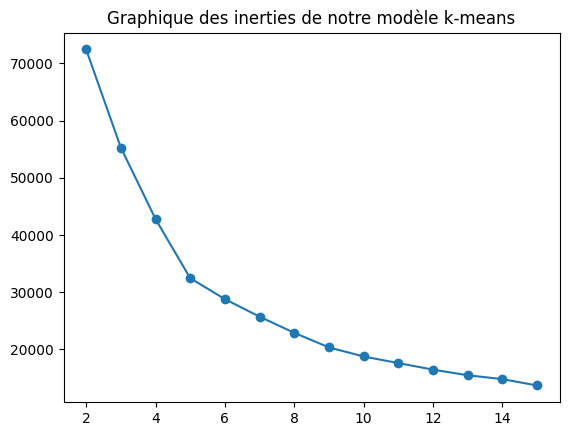

In [ ]:
#On vérifiera que le nombre de clusters idéale est toujours de 4 pour l'échantillon
#Appliquer le k-means
cluster_rangeS = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

inertieS = []

for c in cluster_rangeS:
  kmeans1 = KMeans(init = 'k-means++', n_clusters = c).fit(std_segmented_rfms)
  inertieS.append(kmeans1.inertia_)

#Afficher l'inertie

plt.Figure()
plt.plot(cluster_rangeS,inertieS, marker ='o')
plt.title("Graphique des inerties de notre modèle k-means")
plt.show()

In [ ]:
kmeans_init1 = KMeans(n_clusters= 5, init = 'k-means++', random_state = 42).fit(std_segmented_rfms)
labels_init1 = kmeans_init1.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
kmeans_init1

KMeans(n_clusters=5, random_state=42)

In [ ]:
new_segmented_rfms_init = pd.DataFrame(data = std_segmented_rfms, columns =['recency', 'frequency', 'monetary_value','score_review'])
new_segmented_rfms_init['labels_kmeans'] = labels_init1
new_segmented_rfms_init

,recency,frequency,monetary_value,score_review,labels_kmeans
0,1.180340,-0.156703,-0.324901,-0.759645,3
1,1.263268,-0.156703,-0.053683,-0.136720,3
2,-0.616437,-0.156703,-0.567767,-0.759645,1
3,-0.948150,-0.156703,-0.303424,-0.136720,1
4,-1.031078,-0.156703,0.401828,-1.382570,0
...,...,...,...,...,...
25004,-0.948150,-0.156703,-0.254783,0.486205,1
25005,-1.238398,-0.156703,-0.457412,-0.136720,1
25006,-0.063582,-0.156703,8.084142,0.486205,4
25007,1.608802,-0.156703,-0.213528,0.486205,3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

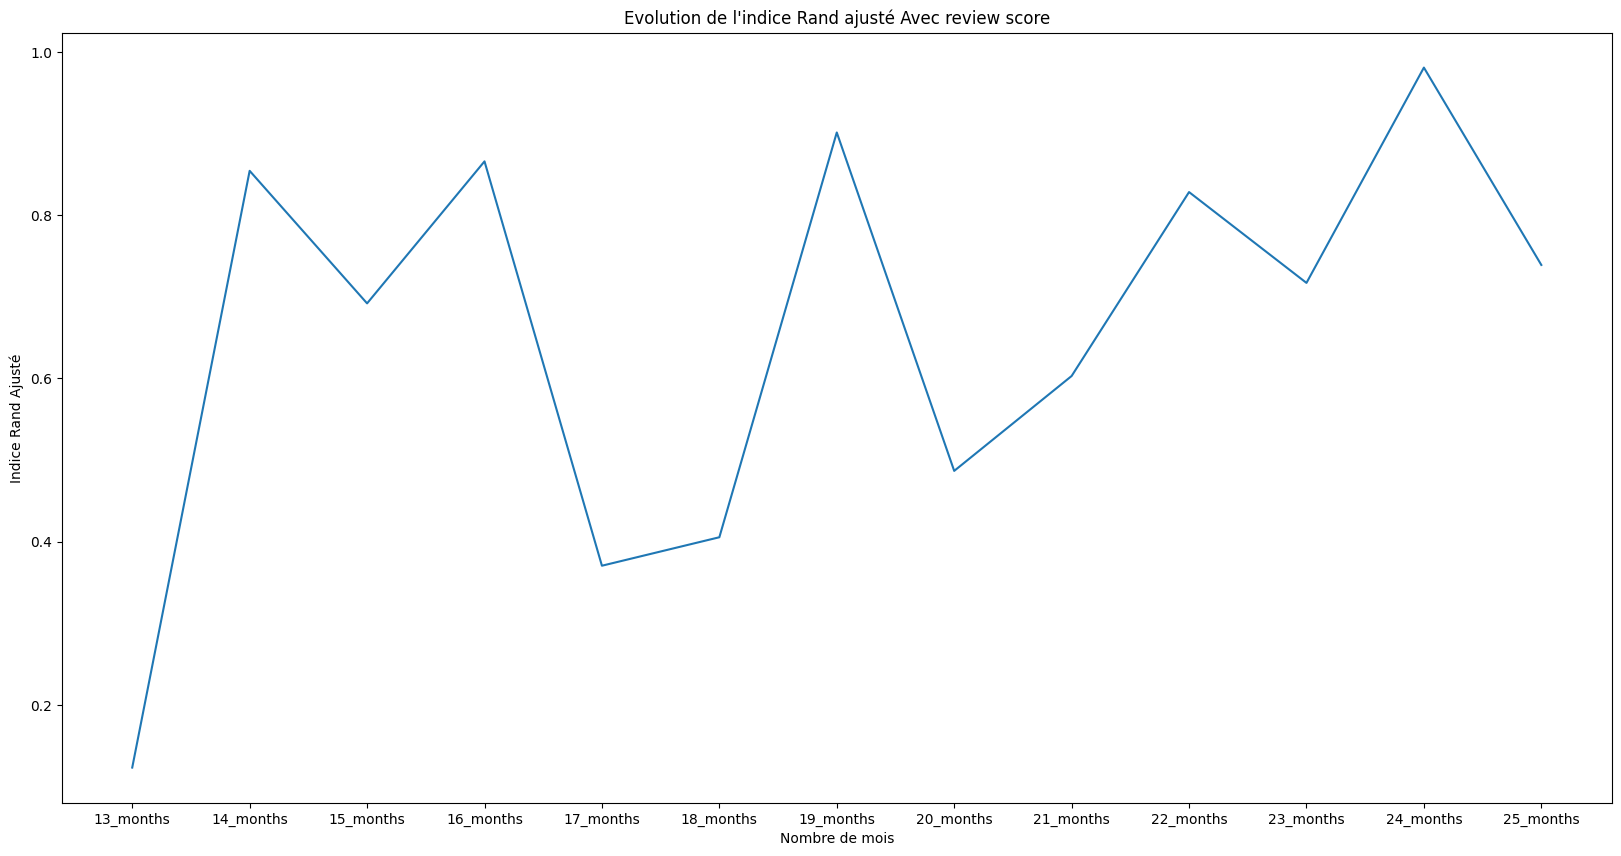

In [ ]:
#On entraine de nouveau modèle pour calculer les ARI
res1 = []
period =['2017-10-17 23:59:59',
         '2017-11-17 23:59:59',
         '2017-12-17 23:59:59',
         '2018-01-17 23:59:59',
         '2018-02-17 23:59:59',
         '2018-03-17 23:59:59',
         '2018-04-17 23:59:59',
         '2018-05-17 23:59:59',
         '2018-06-17 23:59:59',
         '2018-07-17 23:59:59',
         '2018-08-17 23:59:59',
         '2018-09-17 23:59:59',
         '2018-10-17 23:59:59']

labels_limit1 = len(kmeans_init1.labels_)-1

for i in range(len(period)):
  month_res = {}

  data_period = data[data["order_purchase_timestamp"] < pd.to_datetime(period[i])]

  rfmsTable_period = data_period.groupby('customer_unique_id').\
            agg({"order_purchase_timestamp": lambda x: (NOW - x.max()).days,
                  "customer_id": lambda x: len(x.unique()),
                  "payment_value": lambda x: sum(x),
                "review_score": lambda x: sum(x)})

  rfmsTable_period['order_purchase_timestamp'] = rfmsTable_period['order_purchase_timestamp'].astype(int)
  rfmsTable_period.rename(columns={'order_purchase_timestamp': 'recency',
                          'customer_id': 'frequency',
                          'payment_value': 'monetary_value',
                          'review_score': 'score_review'}, inplace=True)

  segmented_rfms_period = rfmsTable_period

  data_period_std = pd.DataFrame(Scal1.transform(segmented_rfms_period), columns= segmented_rfms_period.columns, index=segmented_rfms_period.index)
  labels_before_fit = kmeans_init1.predict(data_period_std)
  fitted_model = kmeans_init1.fit(data_period_std)
  labels_after_fit = fitted_model.predict(data_period_std)
  ari = adjusted_rand_score(labels_before_fit[0:labels_limit1], labels_after_fit[0:labels_limit1])

  #On construit un tableau
  month_res['Date actuel'] = period[i]
  month_res['ARI'] = ari
  res1.append(month_res)

res1 = pd.DataFrame(res1)

months1 = [
          '13_months',
          '14_months',
          '15_months',
          '16_months',
          '17_months',
          '18_months',
          '19_months',
          '20_months',
          '21_months',
          '22_months',
          '23_months',
          '24_months',
          '25_months'
        ]

fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.lineplot(data=res1, x=months1 , y='ARI')
ax.set_xlabel("Nombre de mois")
ax.set_ylabel("Indice Rand Ajusté")
ax.set_title("Evolution de l'indice Rand ajusté Avec review score")
plt.show()

AU regard de la répartition des clusters on peut déduire qu'il serait interessant de prévoir une maintenance tous les 3 mois. pour assurer la stabilité de notre étude